In [3]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import seaborn as sns
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
house_df_org = pd.read_csv('house_price.csv') # 오리지널
house_df = house_df_org.copy() # 커피버전
house_df.head(3)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500


In [5]:
print("shape:", house_df.shape)
print("Data type:\n", house_df.dtypes.value_counts())
isnull_series = house_df.isnull().sum() # 결측치 더하기

shape: (1460, 81)
Data type:
 object     43
int64      35
float64     3
dtype: int64


In [6]:
isnull_series[isnull_series>0].sort_values(ascending=False).head(10) # 결측치가 0봐 큰 부분에 대해서 나타내기. 몇 가지 컬럼은 과도한 숫자의 결측치

PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
FireplaceQu      690
LotFrontage      259
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
dtype: int64

## 타깃값이 정규 분포인지 확인

- 그에대한 이유는 선형 회귀는 타깃값이 정규 분포를 따르는게 아니라, 잔차가 정규 분포를 따른다는 가정하에 만들어진 모델 이기 때문이다.
- skew된 타깃값을  log 변환하면 이런  이슈들을 전반적으로 개선하기 쉽기 때문에 적용한다.

https://socialinnovation.tistory.com/145  
https://datascienceschool.net/view-notebook/2787ec5d30664dea850fe0a940e5c1e4/  
https://walkingwithus.tistory.com/606

<AxesSubplot:title={'center':'Original Sale Price Histogram'}, xlabel='SalePrice', ylabel='Density'>

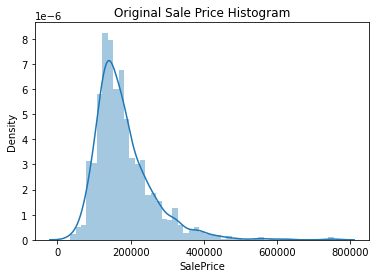

In [7]:
# 타깃값이 약간 skewed되어 있음을 볼 수 있다
plt.title('Original Sale Price Histogram')
sns.distplot(house_df['SalePrice'])

## 타깃값에 대해서 로그 변환을 하기. 나중에 다시 지수변환을 하면 됨

<AxesSubplot:title={'center':'Log Transformed Sale Price Histogram'}, xlabel='SalePrice', ylabel='Density'>

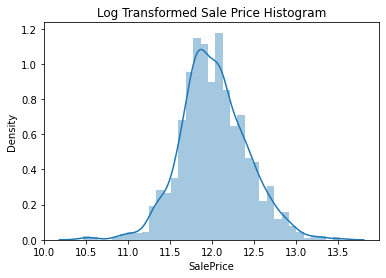

In [8]:
plt.title('Log Transformed Sale Price Histogram')
log_SalePrice = np.log1p(house_df['SalePrice']) # 로그변환을 한 상태에서의 타깃값은 정규분포를 대채ㅔ로 따르게 된다.
sns.distplot(log_SalePrice)

In [9]:
# SalePrice 로그 변환
original_SalePrice = house_df['SalePrice']
house_df['SalePrice'] = np.log1p(house_df['SalePrice'])

In [10]:
# Null이 너무 많은 칼럼과 불필요한 칼럽 삭제
house_df.drop(['Id', 'PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu'], axis=1, inplace=True)

In [11]:
# 드롭하지 않은 숫자형 Null 칼럼은 평균값으로 대체
house_df.fillna(house_df.mean(), inplace=True)

In [12]:
# Null 값이 있는 피처명과 타입을 추출. 숫자형의 칼럼들은 모두 대체값을 가지게 되었으나 string 값의 컬럼들은 결측치가 존재한다.
null_column_count = house_df.isnull().sum()[house_df.isnull().sum() >0]
print('## Null 피처의 Type :\n',house_df.dtypes[null_column_count.index])

## Null 피처의 Type :
 MasVnrType      object
BsmtQual        object
BsmtCond        object
BsmtExposure    object
BsmtFinType1    object
BsmtFinType2    object
Electrical      object
GarageType      object
GarageFinish    object
GarageQual      object
GarageCond      object
dtype: object


### One-hot 인코딩. 문차열 피처를 원-핫 인코딩하면 Null 값은 None 칼럼으로 대체해줌. 그러나 칼럼이 증가함

In [13]:
# 결측치를 null값에서 none값으로 대체해주기 위해서 onehot encoding을 실시한다. 그러나 원핫 인코딩은 칼럼의 수를 증가시킨다. 왜?
# 컬럼_내부값으로 컬럼이 증가한다.

print('get_dummies() 수행 전 데이터 Shape:', house_df.shape)
house_df_ohe = pd.get_dummies(house_df)
print('get_dummies() 수행 후 데이터 Shape:', house_df_ohe.shape)

null_column_count = house_df_ohe.isnull().sum()[house_df_ohe.isnull().sum() >0]
print('## Null 피처의 Type :\n', house_df_ohe.dtypes[null_column_count.index])

get_dummies() 수행 전 데이터 Shape: (1460, 75)
get_dummies() 수행 후 데이터 Shape: (1460, 271)
## Null 피처의 Type :
 Series([], dtype: object)


In [14]:
def get_rmse(model):
    pred = model.predict(X_test)
    mse = mean_squared_error(y_test, pred)
    rmse = np.sqrt(mse)
    print(model.__class__.__name__, '로그 변환된 RMSE:', np.round(rmse, 3))
    return rmse

def get_rmses(models):
    rmses = []
    for model in models:
        rmse = get_rmse(model)
        rmses.append(rmse)
    return rmses

In [15]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error


y_target = house_df_ohe['SalePrice']
X_features = house_df_ohe.drop('SalePrice', axis=1, inplace=False)
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.2, random_state=156)

lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
ridge_reg = Ridge()
ridge_reg.fit(X_train, y_train)
lasso_reg = Lasso()
lasso_reg.fit(X_train, y_train)

models = [lr_reg, ridge_reg, lasso_reg]
get_rmses(models)

LinearRegression 로그 변환된 RMSE: 0.132
Ridge 로그 변환된 RMSE: 0.128
Lasso 로그 변환된 RMSE: 0.176


[0.1318957657915422, 0.12750846334053068, 0.17628250556471406]

### 사용된 회귀 계수 학인 - 독립변수가 종속변수에 얼마만큼의 영향을 미쳤는지 확인하는 과정

In [16]:
def get_top_bottom_coef(model, n=10):
    # coef_ 속성을 기반으로 Series 객체를 생성. index는 칼럼명
    coef = pd.Series(model.coef_, index=X_features.columns) #각 모델마다 coef_를 반환, index는 칼럼명. 해당 칼럼명과 모델 간 coef 속성을 기반으로 Series 객체 생성.
    
    # + 상위 10개, - 하위 10개의 회귀 계수를 추출해 반환.
    coef_high = coef.sort_values(ascending=False).head(n)
    coef_low = coef.sort_values(ascending=False).tail(n)
    return coef_high, coef_low

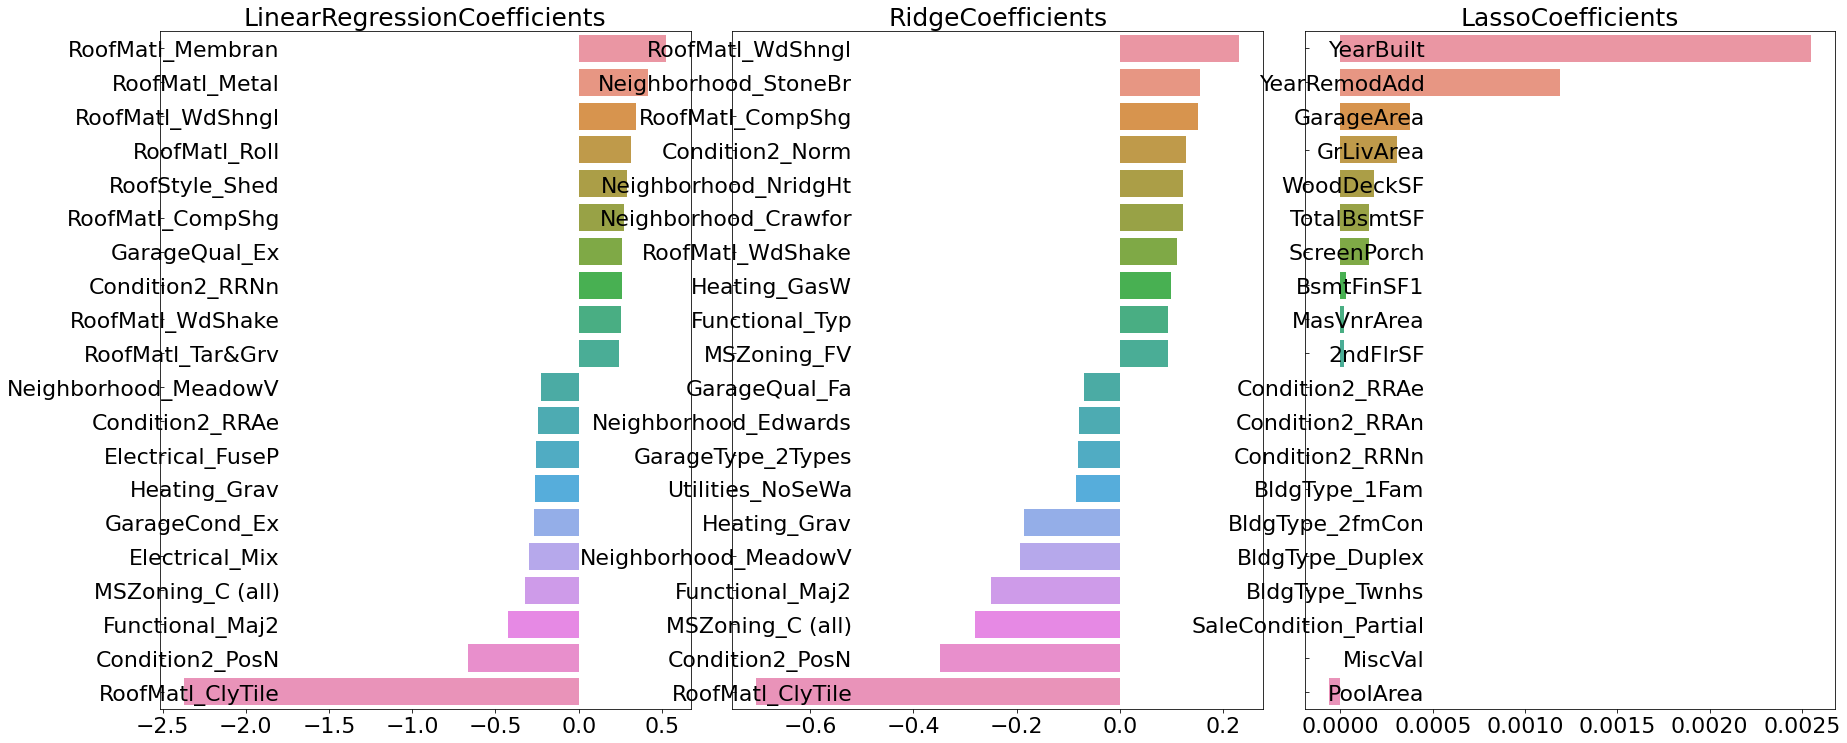

In [17]:
def visualize_coefficient(models):
    fig, axs = plt.subplots(figsize=(24, 10), nrows=1, ncols=3)
    fig.tight_layout()
    
    for i_num, model in enumerate(models):
        coef_high, coef_low = get_top_bottom_coef(model)
        coef_concat = pd.concat([coef_high, coef_low])
        
        axs[i_num].set_title(model.__class__.__name__+'Coefficients', size=25)
        axs[i_num].tick_params(axis="y", direction="in", pad=-120)
        for label in (axs[i_num].get_xticklabels() + axs[i_num].get_yticklabels()):
            label.set_fontsize(22)
        sns.barplot(x=coef_concat.values, y=coef_concat.index, ax=axs[i_num])
        
models= [lr_reg, ridge_reg, lasso_reg]
visualize_coefficient(models)

## LR과 Ridge의 경우에는 coefficient의 회귀 계수가 유사한 형태로 분포되어 있으나 Lasso는 전체적으로 회귀 계수 값이 매우 작고 YearBuilt가 가장 큼. 학습 데이터의 데이터 분할에 문제가 있어서 그런 것인지 확인하기 위해서 Kfold cross validation을 실행

In [22]:
from sklearn.model_selection import cross_val_score

def get_avg_rmse_cv(models):
    for model in models:
        # 분할하지 않고 전체 데이터로 cross_val_score() 수행. 모델별 CV RMSE값과 평균 RMSE 출력
        rmse_list = np.sqrt(-cross_val_score(model, X_features, y_target, scoring = "neg_mean_squared_error", cv=5))
        
        rmse_avg = np.mean(rmse_list)
        print('\n{0} CV RMSE 값 리스트: {1}'.format(model.__class__.__name__, np.round(rmse_list, 3)))
        print('{0} CV 평균 RMSE 값: {1}'.format(model.__class__.__name__, np.round(rmse_avg, 3)))
        
models = [lr_reg, ridge_reg, lasso_reg]
get_avg_rmse_cv(models)


LinearRegression CV RMSE 값 리스트: [0.135 0.165 0.168 0.111 0.198]
LinearRegression CV 평균 RMSE 값: 0.155

Ridge CV RMSE 값 리스트: [0.117 0.154 0.142 0.117 0.189]
Ridge CV 평균 RMSE 값: 0.144

Lasso CV RMSE 값 리스트: [0.161 0.204 0.177 0.181 0.265]
Lasso CV 평균 RMSE 값: 0.198


### 여전히 떨어지는 Lasso의 RMSE값. 두 모델에 대해서 alpha 하이퍼 파라미터를 변화시키면서 최적 값을 도출하는 과정

In [27]:
from sklearn.model_selection import GridSearchCV

def print_best_params(model, params):
    grid_model = GridSearchCV(model, param_grid = params,
                              scoring = 'neg_mean_squared_error', cv=5)
    grid_model.fit(X_features, y_target)
    rmse = np.sqrt(-1*grid_model.best_score_)
    print('{0} 5 CV 시 최적 평균 RMSE 값:{1}, 최적 alpha:{2}'.format(model.__class__.__name__, np.round(rmse,4), grid_model.best_params_))
    
ridge_params = {'alpha':[0.05, 0.1, 1, 5, 8, 10, 12, 15, 20]}
lasso_params = {'alpha':[0.001, 0.005, 0.008, 0.05, 0.03, 0.1, 0.5, 1, 5, 10]}
print_best_params(ridge_reg, ridge_params)
print_best_params(lasso_reg, lasso_params)


Ridge 5 CV 시 최적 평균 RMSE 값:0.1418, 최적 alpha:{'alpha': 12}
Lasso 5 CV 시 최적 평균 RMSE 값:0.142, 최적 alpha:{'alpha': 0.001}


### 선형 모델에 최적 alpha 값을 설정한 뒤, train_test_split()으로 분할된 학습 데이터와 테스트 데이터를 이용해 모델의 학습/예측/평가를 수행하고, 모델별 회귀 계수를 시각화